# ZKsyn data exploration - Fees and gas

#### [Maria Silva](https://github.com/misilva73), June 2024

## Import packages

In [1]:
import os
import polars as pl
import plotly.graph_objects as go

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

Note that these are support functions defined in the `src` folder:

In [3]:
from plot_utils import get_plotly_layout, colors

width, height = 800, 450

##  Load Polars DataFrames

In [4]:
# Set directory paths
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [5]:
# Load blocks data
blocks_path = os.path.join(data_dir, "blocks", "blocks_*.parquet")
blocks_lazy_df = (
    pl.scan_parquet(blocks_path)
    .with_columns(pl.from_epoch("timestamp", time_unit="s"))
    .sort("timestamp")
)
blocks_lazy_df.schema

OrderedDict([('hash', String),
             ('parentHash', String),
             ('sha3Uncles', String),
             ('miner', String),
             ('stateRoot', String),
             ('transactionsRoot', String),
             ('receiptsRoot', String),
             ('number', Int64),
             ('l1BatchNumber', String),
             ('gasUsed', Int64),
             ('gasLimit', Int64),
             ('baseFeePerGas', Int64),
             ('extraData', String),
             ('logsBloom', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('l1BatchTimestamp', String),
             ('difficulty', Int64),
             ('totalDifficulty', Int64),
             ('sealFields', List(Null)),
             ('uncles', List(Null)),
             ('size', Int64),
             ('mixHash', String),
             ('nonce', String)])

In [6]:
# Load transaction data
txs_path = os.path.join(data_dir, "transactions", "transactions_*.parquet")
txs_lazy_df = (
    pl.scan_parquet(txs_path)
    .join(blocks_lazy_df.select(["number", "timestamp"]), left_on="blockNumber", right_on="number")
    .sort("timestamp")
)
txs_lazy_df.schema

OrderedDict([('blockHash', String),
             ('blockNumber', Int64),
             ('chainId', Int64),
             ('from', String),
             ('gas', Int64),
             ('gasPrice', Int64),
             ('hash', String),
             ('input', String),
             ('l1BatchNumber', String),
             ('l1BatchTxIndex', String),
             ('maxFeePerGas', Int64),
             ('maxPriorityFeePerGas', Int64),
             ('nonce', Int64),
             ('r', String),
             ('s', String),
             ('to', String),
             ('transactionIndex', Int64),
             ('type', Int64),
             ('v', Float64),
             ('value', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None))])

##  Process Polars DataFrames

In [7]:
# Compute daily aggregated data for blocks
block_data_per_day_df = (
    blocks_lazy_df
    .group_by_dynamic("timestamp", every="1d")
    .agg(
        pl.col("gasUsed").mean().alias("avg_gas_used_block"),
        pl.col("gasUsed").sum().alias("total_gas_used_day"),
        pl.col("baseFeePerGas").mean().alias("avg_base_fee_price_block")
    )
    .collect(streaming=True)
    .to_pandas()
    [2:] # Ignoring the first two days!
)
block_data_per_day_df.head()

,timestamp,avg_gas_used_block,total_gas_used_day,avg_base_fee_price_block
2,2023-02-15,9.003049e+06,243082312,4.351852e+08
3,2023-02-16,8.119228e+06,1031141995,2.500000e+08
4,2023-02-17,8.302870e+06,332114816,2.500000e+08
5,2023-02-18,2.796055e+05,559211,2.500000e+08
6,2023-02-19,2.713770e+05,542754,2.500000e+08


In [8]:
# Compute daily aggregated data for transactions
tx_data_per_day_df = (
    txs_lazy_df
    .group_by_dynamic("timestamp", every="1d")
    .agg(
        pl.col("gas").mean().alias("avg_gas_used_tx"),
        pl.col("gas").sum().alias("total_gas_used_day"),
        pl.col("gasPrice").mean().alias("avg_gas_price_tx"),
        pl.col("maxFeePerGas").mean().alias("avg_max_price_tx"),
        pl.col("maxPriorityFeePerGas").mean().alias("avg_max_prio_price_tx")
    )
    .collect(streaming=True)
    .to_pandas()
    [2:] # Ignoring the first two days!
)
tx_gas_per_day_df.head()

InvalidOperationError: argument in operation 'group_by_dynamic' is not sorted, please sort the 'expr/series/column' first

## Gas usage analysis

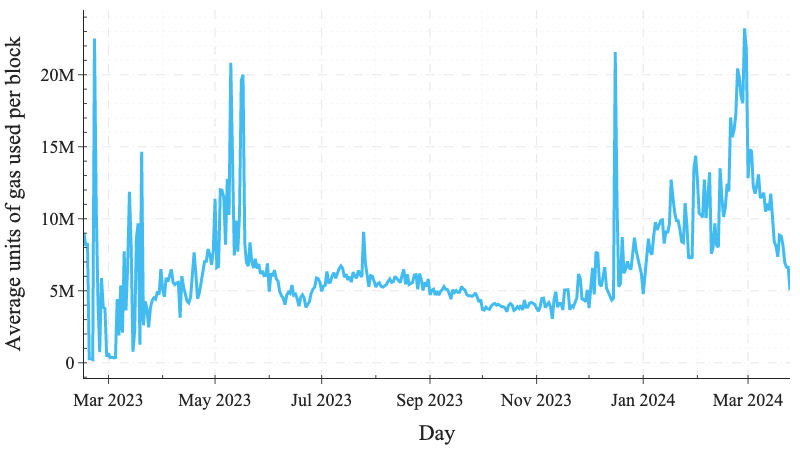

In [10]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df['timestamp'], 
    y=block_data_per_day_df['avg_gas_used_block'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(yaxis_title="Average units of gas used per block",
                  xaxis_title="Day", legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-gas-used-block.pdf'))
fig.show('png')

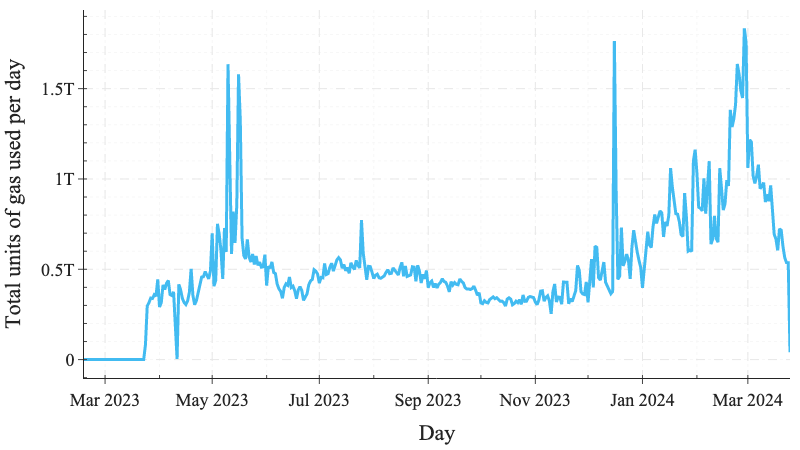

In [11]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:]['timestamp'], 
    y=block_data_per_day_df.iloc[2:]['total_gas_used_day'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(yaxis_title="Total units of gas used per day",
                  xaxis_title="Day", legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'daily-total-gas-used.pdf'))
fig.show('png')